# Look at effect of segment size for Student's _t_-distribution


In the known pulsar parameter estimation code the standard likelihood used is the product of multiple ($N$) Student's _t_-distributions for data segments of different lengths, $n_i$, (i.e. different numbers of degrees of freedom), where in each segment the data, $\{d\}_i$, is assumed to be stationary:
$$
\mathcal{L} \propto \prod_{i=1}^N \sum_{j=1}^{n_i} \left(d_j-m_j\right)^{-{n_i}/2}
$$
Here we look at the effect that changing the segment size (number of degrees of freedom), when using stationary white Gaussian noise, has on the width of the distribution.

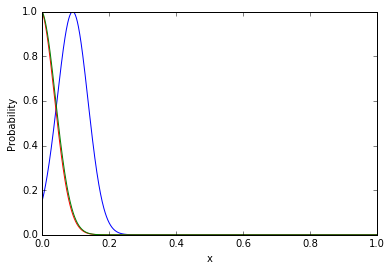

In [10]:
%matplotlib inline

from matplotlib import pyplot as pl
import numpy as np

# create some random noise
dlen = 500
data = np.random.randn(dlen)

xs = np.linspace(0, 1.0, 1000)

# set the segment (chunk) lengths into which to break the data  
chunklengths = [5, 50, 100]
colors = ['b','r','g']

# use Student's t-likelihood with joint likelihood being the product of the likelihoods for different chunk lengths
for k, cl in enumerate(chunklengths):
    likest = np.zeros(len(xs))
    #likegauss = np.zeros(len(xs))
    for i in range(0, dlen/cl):
        var = np.var(data[i*cl:(i+1)*cl]) # data chunk variance estimate
        for j in range(len(xs)):
            likest[j] += -(cl/2)*np.log(np.sum((data[i*cl:(i+1)*cl]-xs[j])**2))
            #likegauss[j] += -np.sum(0.5*(data[i*cl:(i+1)*cl]-xs[j])**2/var)

    pl.plot(xs, np.exp(likest-np.max(likest)), colors[k])
    pl.ylabel('Probability')
    pl.xlabel('x')
    #pl.plot(xs, np.exp(likegauss-np.max(likegauss)), colors[k], linestyle='--')


It can be seen from running the above example several times that the probability distributions for the '50' and '100' chunk length analyses generally look very similar. However, for the case of chunk lengths of '5' the distribution can change a lot; sometimes being narrower than those using large chunk lengths, but sometimes being far wider. This is shown below by where the above examples if run multiple times and a 95% upper limit is used as a proxy for the width of the distribution.

In [11]:
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

# Do the same, but multiple times and get the 95% upper limits form each
iterations = 200
h0ulsst = np.ndarray((iterations, len(chunklengths)))
h0ulsgauss = np.ndarray((iterations, len(chunklengths)))
for z in range(iterations):
    data = np.random.randn(dlen)
    for k, cl in enumerate(chunklengths):
        loglikest = np.zeros(len(xs))
        #loglikegauss = np.zeros(len(xs))
        for i in range(0, dlen/cl):
            var = np.var(data[i*cl:(i+1)*cl]) # data chunk variance estimate
            for j in range(len(xs)):
                loglikest[j] += -(cl/2)*np.log(np.sum((data[i*cl:(i+1)*cl]-xs[j])**2))
                #loglikegauss[j] += -np.sum(0.5*(data[i*cl:(i+1)*cl]-xs[j])**2/var)

        likest = np.exp(loglikest-np.max(loglikest))
        #likegauss = np.exp(loglikegauss-np.max(loglikegauss))

        csst = cumtrapz(likest, xs)/np.trapz(likest, xs)
        #csgauss = cumtrapz(likegauss, xs)/np.trapz(likegauss, xs)
        
        # get upper limits
        u, indices = np.unique(csst, return_index=True)
        intcsst = interp1d(u, xs[indices], kind='linear')
        h0ulsst[z,k] = intcsst(0.95)

        #u, indices = np.unique(csgauss, return_index=True)
        #intcsgauss = interp1d(u, xs[indices], kind='linear')
        #h0ulsgauss[z,k] = intcsgauss(0.95)

The distribution of upper limits for each of the different chunk lengths.

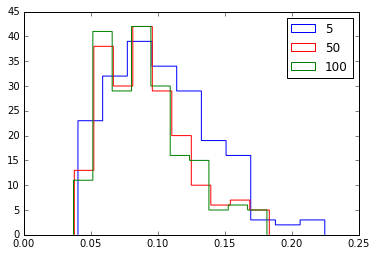

In [16]:
pl.hist(h0ulsst[:,0], bins=10, histtype='step', color='b', label='5')
pl.hist(h0ulsst[:,1], bins=10, histtype='step', color='r', label='50')
pl.hist(h0ulsst[:,2], bins=10, histtype='step', color='g', label='100')
pl.legend()

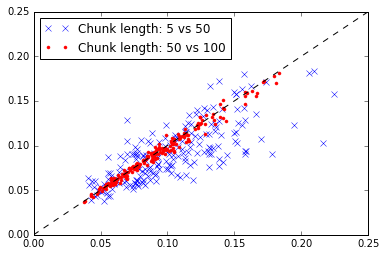

In [14]:
pl.plot(h0ulsst[:,0], h0ulsst[:,1], 'bx', label='Chunk length: 5 vs 50')
pl.plot(h0ulsst[:,1], h0ulsst[:,2], 'r.', label='Chunk length: 50 vs 100')
pl.plot([0., 0.25], [0., 0.25], 'k--')
pl.legend(loc='best')